In [8]:
# Utils
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
import pickle
import re, sys, unidecode

from sklearn.metrics import accuracy_score
from IPython.display import display, Markdown, Latex

import shutil
import os


import scikitplot as skplt

from tensorflow.contrib.learn import DNNClassifier



# Parameters

In [9]:
root_path = "../"
path_model = root_path + 'models/test'
features_path = root_path + 'data/features/data_tfid_hash28_n1000.p'

delete_old_model = True
if delete_old_model:
    try:
        os.system("rm -rf "+path_model)
        os.system("mkdir "+path_model)
    except:
        print("error")

# Load Data

In [10]:
X, y1, y2, y3 = pickle.load( open( features_path, "rb" ) )


In [12]:
y1.values

array(['deportes', 'pais', 'pais', ..., 'cultura', 'pais', 'mundo'],
      dtype=object)

# pre procesing

Cleaning data, select clases

In [13]:
y2 = np.array(y2)
y_2 = list(map(lambda x: unidecode.unidecode(x) if x!=None else None, y2))
y_2 = np.array(y_2)


y1 = y1.values

# Feature Extraccion

### Data representation

TFID calculation

### filter clases

In [15]:
labels = list(set(y1))
labels

['entretencion',
 'sociedad',
 'pais',
 'economia',
 'tecnologia',
 'deportes',
 'cultura',
 'mundo']

In [16]:
def filterClases(X,y,umbral):
    labels = list(set(y))
    sizes = [ [label,y[y== label].shape[0]] for label in labels ]
    filter_sizes = list(filter(lambda x:x[1]>umbral ,sizes ))
    names_clases = set( map(lambda x:x[0], filter_sizes ) )
    index = list(map(lambda x: {x}.issubset(names_clases), y ))
    y = y[index]
    X = X[np.nonzero(index)]
    return X,y



In [44]:
y_temas = {}
X_temas = {}
labels_temas = {}
labels_temas_before = {}
umbral_ejemplos = 100

for key in labels:
    index = y1 == key
    y_22 = y_2[index]
    X2 = X[np.nonzero(index)]

    index = y_22 != None
    y_22 = y_22[index]
    X2 = X2[np.nonzero(index)]
    X_temas[key],y_temas[key] = filterClases(X2,y_22,umbral_ejemplos)
    
    
    labels_temas_before = list(set(y_22))
    labels_temas[key] = list(set(y_temas[key]))
    
    print("\n"+key + " ,total : " + str(len(labels_temas[key])) \
          +" ,deleted : "+ str( len(labels_temas_before) - len(labels_temas[key] )) )
    print(labels_temas[key])



entretencion ,total : 14 ,deleted : 4
['comic', 'personajes', 'panoramas', 'festivales', 'sucesos', 'espectaculos', 'radio', 'humor', 'cine', 'listas', 'television', 'festival de vina', 'musica', 'tendencias']

sociedad ,total : 17 ,deleted : 12
['pedofilia', 'fauna', 'religion', 'medios', 'sucesos', 'ciencias sociales', 'ciencia', 'salud', 'historia', 'sexualidad', 'desarrollo humano', 'mujer', 'astronomia', 'celebraciones', 'homosexualidad', 'medioambiente', 'premios nobel']

pais ,total : 52 ,deleted : 15
['presidente pinera', 'isla de pascua', 'vivienda', 'energia', 'educacion', 'region de arica', 'sebastian pinera', 'medioambiente', 'presidenta bachelet', 'judicial', 'poblacion', 'ddhh', 'desastres naturales', 'region del maule', 'infancia', 'servicios', 'ciudades', 'region de valparaiso', 'trabajo', 'mujer', 'region de la araucania', 'seguridad ciudadana', 'region de antofagasta', 'ffaa y de orden', 'region de los rios', 'organismos del estado', 'pueblos originarios', 'policial'

### Output

In [18]:
np.random.seed(42)
train_fraction = 0.8

X_train = {}
y_train = {}
X_test = {}
y_test = {}
train_indices = {}
test_indices = {}

for key in labels:
    train_indices[key] = np.random.choice(X_temas[key].shape[0], round(train_fraction*X_temas[key].shape[0]), replace=False)
    test_indices[key] = np.array(list(set(range(X_temas[key].shape[0])) - set(train_indices)))

    X_train[key] = X_temas[key][train_indices[key]]
    y_train[key] = y_temas[key][train_indices[key]]
    X_test[key] = X_temas[key][test_indices[key]]
    y_test[key] = y_temas[key][test_indices[key]]

In [19]:
weights_train = {}
weights_test = {}

np.random.seed(42)

for key in labels:
    labelsTmp = list(set(y_train[key]))
    nClasses = len(labelsTmp)

    sizes = {label: y_train[key][y_train[key] == label].shape[0] for label in labelsTmp}
    weights = np.asarray([len(y_train[key])/(sizes[label]*nClasses) for label in y_temas[key]])

    weights = weights[:,np.newaxis]
    weights_train[key] = weights[train_indices[key]]
    weights_test[key] = weights[test_indices[key]]

    

# Model

### DNN graph generation

In [20]:
epochs = 14000

# Define the test inputs
def get_train_inputs(key):    
    dataset = tf.estimator.inputs.numpy_input_fn({'x': X_train[key].todense(),'class_weights': weights_train[key]},
                                                  y_train[key][:,np.newaxis],
                                                  shuffle=True,
                                                  batch_size=500,
                                                  num_epochs=epochs)
    return dataset

def get_test_inputs(key):   
    dataset = tf.estimator.inputs.numpy_input_fn({'x': X_test[key].todense(),'class_weights': weights_test[key]},
                                                  y_test[key][:,np.newaxis],
                                                  shuffle=False)
    return dataset

### functions graph tensorflow

In [21]:


tf.set_random_seed(42)
feature_columns = [tf.contrib.layers.real_valued_column('x', dimension=1000)]

classifier = {}
for key in labels:
    classifier[key] = DNNClassifier(                                
                               n_classes=len(labels_temas[key]), label_keys=labels_temas[key], feature_columns=feature_columns,
                               hidden_units=[2000],
                               dropout=0.5,
                               weight_column_name='class_weights',
                               model_dir = path_model+"/"+str(key),
                               config = tf.contrib.learn.RunConfig(save_checkpoints_steps = 500,
                               save_checkpoints_secs = None)                           
                              )

Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f55b171c8d0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': 500, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '../models/test/entretencion'}
INFO:tensorflow:Usi

# Training



In [22]:
#validation_monitor = {}

print("start")
start = time.time()

for key in labels:
    
    validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
        #input_fn= get_train_inputs(),
        input_fn= get_test_inputs(key),    
        every_n_steps=500,
        #early_stopping_metric="accuracy",#loss
        early_stopping_metric="loss",
        early_stopping_metric_minimize=True,
        early_stopping_rounds=2000)

    

    classifier[key].fit(input_fn=get_train_inputs(key), monitors=[validation_monitor], steps=epochs, max_steps=None)
    print("###################### "+key+" ######################")
    
end = time.time()
#print(key)
print("Training time :" + str(end - start) )


start
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ../models/test/entretencion/model.ckpt.
INFO:tensorflow:loss = 2.5515919, step = 0
INFO:tensorflow:global_step/sec: 64.523
INFO:tensorflow:loss = 3.0628488, step = 100 (1.558 sec)
INFO:tensorflow:global_step/sec: 68.6673
INFO:tensorflow:loss = 2.9759772, step = 200 (1.457 sec)
INFO:tensorflow:global_step/sec: 68.3079
INFO:tensorflow:loss = 2.0356479, step = 300 (1.458 sec)
INFO:tensorflow:global_step/sec: 69.7681
INFO:tensorflow:loss = 2.6067383, step = 400 (1.432 sec)
INFO:tensorflow:Saving checkpoints for 501 into ../m

INFO:tensorflow:global_step/sec: 65.1092
INFO:tensorflow:Starting evaluation at 2018-10-04-00:05:57
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/entretencion/model.ckpt-3501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00:05:58
INFO:tensorflow:Saving dict for global step 3501: accuracy = 0.80397713, global_step = 3501, loss = 0.71646005
INFO:tensorflow:Validation (step 3500): loss = 0.71646005, accuracy = 0.80397713, global_step = 3501
INFO:tensorflow:loss = 0.4593734, step = 3500 (2.747 sec)
INFO:tensorflow:global_step/sec: 37.0015
INFO:tensorflow:loss = 0.67370796, step = 3600 (1.489 sec)
INFO:tensorflow:global_step/sec: 67.7764
INFO:tensorflow:loss = 0.57723534, step = 3700 (1.475 sec)
INFO:tensorflow:global_step/sec: 68.0865
INFO:tensorflow:loss = 0.5659738, step = 3800 (1.469 sec)
INFO:tensorflow:global_step/sec: 67.4505
INFO:tensorflow:loss = 0.

INFO:tensorflow:Saving dict for global step 7001: accuracy = 0.8471975, global_step = 7001, loss = 0.6103725
INFO:tensorflow:Validation (step 7000): loss = 0.6103725, accuracy = 0.8471975, global_step = 7001
INFO:tensorflow:loss = 0.356339, step = 7000 (2.784 sec)
INFO:tensorflow:global_step/sec: 36.5406
INFO:tensorflow:loss = 0.3412501, step = 7100 (1.501 sec)
INFO:tensorflow:global_step/sec: 67.3328
INFO:tensorflow:loss = 0.29426157, step = 7200 (1.485 sec)
INFO:tensorflow:global_step/sec: 68.6696
INFO:tensorflow:loss = 0.27451208, step = 7300 (1.455 sec)
INFO:tensorflow:global_step/sec: 68.0213
INFO:tensorflow:loss = 0.29487658, step = 7400 (1.471 sec)
INFO:tensorflow:Saving checkpoints for 7501 into ../models/test/entretencion/model.ckpt.
INFO:tensorflow:global_step/sec: 63.7576
INFO:tensorflow:Starting evaluation at 2018-10-04-00:07:06
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/entretencion/model.ckpt-7501
INFO:tensorflow:Running 

INFO:tensorflow:global_step/sec: 67.5975
INFO:tensorflow:loss = 0.2761711, step = 10700 (1.479 sec)
INFO:tensorflow:global_step/sec: 67.7797
INFO:tensorflow:loss = 0.2785386, step = 10800 (1.477 sec)
INFO:tensorflow:global_step/sec: 68.1809
INFO:tensorflow:loss = 0.22489044, step = 10900 (1.465 sec)
INFO:tensorflow:Saving checkpoints for 11001 into ../models/test/entretencion/model.ckpt.
INFO:tensorflow:global_step/sec: 64.7
INFO:tensorflow:Starting evaluation at 2018-10-04-00:08:06
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/entretencion/model.ckpt-11001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00:08:07
INFO:tensorflow:Saving dict for global step 11001: accuracy = 0.8540783, global_step = 11001, loss = 0.60349125
INFO:tensorflow:Validation (step 11000): loss = 0.60349125, accuracy = 0.8540783, global_step = 11001
INFO:tensorflow:loss = 0.2606618

INFO:tensorflow:global_step/sec: 47.9722
INFO:tensorflow:loss = 1.102541, step = 1600 (1.435 sec)
INFO:tensorflow:global_step/sec: 68.0924
INFO:tensorflow:loss = 1.047748, step = 1700 (1.467 sec)
INFO:tensorflow:global_step/sec: 68.114
INFO:tensorflow:loss = 1.0948583, step = 1800 (1.469 sec)
INFO:tensorflow:global_step/sec: 69.699
INFO:tensorflow:loss = 0.9924045, step = 1900 (1.435 sec)
INFO:tensorflow:Saving checkpoints for 2001 into ../models/test/sociedad/model.ckpt.
INFO:tensorflow:global_step/sec: 67.4111
INFO:tensorflow:Starting evaluation at 2018-10-04-00:09:06
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/sociedad/model.ckpt-2001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00:09:07
INFO:tensorflow:Saving dict for global step 2001: accuracy = 0.7360658, global_step = 2001, loss = 0.98263013
INFO:tensorflow:Validation (step 2000): loss = 0.982

INFO:tensorflow:global_step/sec: 66.4584
INFO:tensorflow:Starting evaluation at 2018-10-04-00:10:03
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/sociedad/model.ckpt-5501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00:10:03
INFO:tensorflow:Saving dict for global step 5501: accuracy = 0.8542516, global_step = 5501, loss = 0.5535949
INFO:tensorflow:Validation (step 5500): loss = 0.5535949, accuracy = 0.8542516, global_step = 5501
INFO:tensorflow:loss = 0.4033546, step = 5500 (2.159 sec)
INFO:tensorflow:global_step/sec: 47.4729
INFO:tensorflow:loss = 0.3438646, step = 5600 (1.451 sec)
INFO:tensorflow:global_step/sec: 67.6425
INFO:tensorflow:loss = 0.35503307, step = 5700 (1.478 sec)
INFO:tensorflow:global_step/sec: 67.5408
INFO:tensorflow:loss = 0.35750306, step = 5800 (1.481 sec)
INFO:tensorflow:global_step/sec: 68.0453
INFO:tensorflow:loss = 0.32522598

INFO:tensorflow:Validation (step 9000): loss = 0.48842922, accuracy = 0.87751967, global_step = 9001
INFO:tensorflow:loss = 0.22073399, step = 9000 (2.271 sec)
INFO:tensorflow:global_step/sec: 45.0222
INFO:tensorflow:loss = 0.22805066, step = 9100 (1.450 sec)
INFO:tensorflow:global_step/sec: 68.6452
INFO:tensorflow:loss = 0.19987594, step = 9200 (1.456 sec)
INFO:tensorflow:global_step/sec: 68.3589
INFO:tensorflow:loss = 0.19195871, step = 9300 (1.463 sec)
INFO:tensorflow:global_step/sec: 70.0117
INFO:tensorflow:loss = 0.21519521, step = 9400 (1.430 sec)
INFO:tensorflow:Saving checkpoints for 9501 into ../models/test/sociedad/model.ckpt.
INFO:tensorflow:global_step/sec: 65.7096
INFO:tensorflow:Starting evaluation at 2018-10-04-00:11:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/sociedad/model.ckpt-9501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00:

INFO:tensorflow:global_step/sec: 68.9617
INFO:tensorflow:loss = 0.15121576, step = 12800 (1.450 sec)
INFO:tensorflow:global_step/sec: 68.715
INFO:tensorflow:loss = 0.15884152, step = 12900 (1.457 sec)
INFO:tensorflow:Saving checkpoints for 13001 into ../models/test/sociedad/model.ckpt.
INFO:tensorflow:global_step/sec: 67.0145
INFO:tensorflow:Starting evaluation at 2018-10-04-00:12:03
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/sociedad/model.ckpt-13001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00:12:04
INFO:tensorflow:Saving dict for global step 13001: accuracy = 0.8907778, global_step = 13001, loss = 0.47342262
INFO:tensorflow:Validation (step 13000): loss = 0.47342262, accuracy = 0.8907778, global_step = 13001
INFO:tensorflow:loss = 0.16181761, step = 13000 (2.255 sec)
INFO:tensorflow:global_step/sec: 45.6771
INFO:tensorflow:loss = 0.1509231, st

INFO:tensorflow:Validation (step 2500): loss = 2.4114187, accuracy = 0.4858212, global_step = 2501
INFO:tensorflow:loss = 2.2440348, step = 2500 (3.800 sec)
INFO:tensorflow:global_step/sec: 26.9637
INFO:tensorflow:loss = 2.7690299, step = 2600 (1.442 sec)
INFO:tensorflow:global_step/sec: 69.2474
INFO:tensorflow:loss = 2.1102936, step = 2700 (1.445 sec)
INFO:tensorflow:global_step/sec: 69.5968
INFO:tensorflow:loss = 2.3120887, step = 2800 (1.436 sec)
INFO:tensorflow:global_step/sec: 67.7232
INFO:tensorflow:loss = 2.0174859, step = 2900 (1.478 sec)
INFO:tensorflow:Saving checkpoints for 3001 into ../models/test/pais/model.ckpt.
INFO:tensorflow:global_step/sec: 65.7825
INFO:tensorflow:Starting evaluation at 2018-10-04-00:13:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/pais/model.ckpt-3001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00:13:18
INFO:tens

INFO:tensorflow:Saving checkpoints for 6501 into ../models/test/pais/model.ckpt.
INFO:tensorflow:global_step/sec: 66.3163
INFO:tensorflow:Starting evaluation at 2018-10-04-00:14:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/pais/model.ckpt-6501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00:14:25
INFO:tensorflow:Saving dict for global step 6501: accuracy = 0.64178985, global_step = 6501, loss = 1.3946524
INFO:tensorflow:Validation (step 6500): loss = 1.3946524, accuracy = 0.64178985, global_step = 6501
INFO:tensorflow:loss = 1.2591991, step = 6500 (3.816 sec)
INFO:tensorflow:global_step/sec: 26.4264
INFO:tensorflow:loss = 1.2152203, step = 6600 (1.477 sec)
INFO:tensorflow:global_step/sec: 69.6256
INFO:tensorflow:loss = 1.4011303, step = 6700 (1.436 sec)
INFO:tensorflow:global_step/sec: 69.7994
INFO:tensorflow:loss = 1.3532072, step = 6800 (1.434 se

INFO:tensorflow:Validation (step 10000): loss = 1.1382143, accuracy = 0.70125586, global_step = 10001
INFO:tensorflow:loss = 1.1363846, step = 10000 (3.846 sec)
INFO:tensorflow:global_step/sec: 26.5605
INFO:tensorflow:loss = 1.0692533, step = 10100 (1.513 sec)
INFO:tensorflow:global_step/sec: 66.0523
INFO:tensorflow:loss = 1.2487559, step = 10200 (1.515 sec)
INFO:tensorflow:global_step/sec: 65.8696
INFO:tensorflow:loss = 0.8643144, step = 10300 (1.520 sec)
INFO:tensorflow:global_step/sec: 65.9528
INFO:tensorflow:loss = 1.0692995, step = 10400 (1.515 sec)
INFO:tensorflow:Saving checkpoints for 10501 into ../models/test/pais/model.ckpt.
INFO:tensorflow:global_step/sec: 64.474
INFO:tensorflow:Starting evaluation at 2018-10-04-00:15:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/pais/model.ckpt-10501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00:15:43


INFO:tensorflow:loss = 0.9735144, step = 13800 (1.439 sec)
INFO:tensorflow:global_step/sec: 69.1067
INFO:tensorflow:loss = 0.84817344, step = 13900 (1.448 sec)
INFO:tensorflow:Saving checkpoints for 14000 into ../models/test/pais/model.ckpt.
INFO:tensorflow:Loss for final step: 0.7656341.
###################### pais ######################
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ../models/test/economia/model.ckpt.
INFO:tensorflow:loss = 2.8669882, step = 0
INFO:tensorflow:global_step/sec: 65.5274
INFO:tensorflow:loss = 2.5865993, step = 100 (1.529 sec)
INFO:tensorflow:global_step/sec: 69.5276
INFO:tensorflow:loss = 2.4313695, step = 200 (1.439 sec)
INFO:tensorflow:global_step/sec: 69.4137
INFO:tensorflow:loss = 2.196837, step = 300 (1.440 sec)
INFO:tensorflow:global_step/sec: 68.67
INFO:tensorflow:loss = 2.0234385, step

INFO:tensorflow:Validation (step 3500): loss = 0.43789208, accuracy = 0.8846193, global_step = 3501
INFO:tensorflow:loss = 0.41971272, step = 3500 (2.147 sec)
INFO:tensorflow:global_step/sec: 48.6517
INFO:tensorflow:loss = 0.36910102, step = 3600 (1.458 sec)
INFO:tensorflow:global_step/sec: 68.3975
INFO:tensorflow:loss = 0.37358356, step = 3700 (1.462 sec)
INFO:tensorflow:global_step/sec: 67.541
INFO:tensorflow:loss = 0.304665, step = 3800 (1.481 sec)
INFO:tensorflow:global_step/sec: 68.4395
INFO:tensorflow:loss = 0.33854148, step = 3900 (1.460 sec)
INFO:tensorflow:Saving checkpoints for 4001 into ../models/test/economia/model.ckpt.
INFO:tensorflow:global_step/sec: 65.2907
INFO:tensorflow:Starting evaluation at 2018-10-04-00:17:53
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/economia/model.ckpt-4001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00:17:5

INFO:tensorflow:loss = 0.17281589, step = 7300 (1.441 sec)
INFO:tensorflow:global_step/sec: 67.3534
INFO:tensorflow:loss = 0.16763426, step = 7400 (1.485 sec)
INFO:tensorflow:Saving checkpoints for 7501 into ../models/test/economia/model.ckpt.
INFO:tensorflow:global_step/sec: 65.3813
INFO:tensorflow:Starting evaluation at 2018-10-04-00:18:49
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/economia/model.ckpt-7501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00:18:49
INFO:tensorflow:Saving dict for global step 7501: accuracy = 0.924954, global_step = 7501, loss = 0.30035895
INFO:tensorflow:Validation (step 7500): loss = 0.30035895, accuracy = 0.924954, global_step = 7501
INFO:tensorflow:loss = 0.1655666, step = 7500 (2.114 sec)
INFO:tensorflow:global_step/sec: 49.0581
INFO:tensorflow:loss = 0.15410517, step = 7600 (1.452 sec)
INFO:tensorflow:global_step/s

INFO:tensorflow:Restoring parameters from ../models/test/economia/model.ckpt-11001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00:19:45
INFO:tensorflow:Saving dict for global step 11001: accuracy = 0.93101126, global_step = 11001, loss = 0.2776552
INFO:tensorflow:Validation (step 11000): loss = 0.2776552, accuracy = 0.93101126, global_step = 11001
INFO:tensorflow:loss = 0.08199907, step = 11000 (2.108 sec)
INFO:tensorflow:global_step/sec: 49.1218
INFO:tensorflow:loss = 0.09874307, step = 11100 (1.442 sec)
INFO:tensorflow:global_step/sec: 69.764
INFO:tensorflow:loss = 0.09174388, step = 11200 (1.435 sec)
INFO:tensorflow:global_step/sec: 67.7386
INFO:tensorflow:loss = 0.09194889, step = 11300 (1.475 sec)
INFO:tensorflow:global_step/sec: 69.5972
INFO:tensorflow:loss = 0.08926545, step = 11400 (1.436 sec)
INFO:tensorflow:Saving checkpoints for 11501 into ../models/test/economia/model.ckpt.
INFO:tensorf

INFO:tensorflow:global_step/sec: 71.6486
INFO:tensorflow:loss = 0.6455497, step = 700 (1.397 sec)
INFO:tensorflow:global_step/sec: 71.5625
INFO:tensorflow:loss = 0.55529, step = 800 (1.396 sec)
INFO:tensorflow:global_step/sec: 71.5966
INFO:tensorflow:loss = 0.56222427, step = 900 (1.398 sec)
INFO:tensorflow:Saving checkpoints for 1001 into ../models/test/tecnologia/model.ckpt.
INFO:tensorflow:global_step/sec: 68.269
INFO:tensorflow:Starting evaluation at 2018-10-04-00:20:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/tecnologia/model.ckpt-1001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00:20:48
INFO:tensorflow:Saving dict for global step 1001: accuracy = 0.7961065, global_step = 1001, loss = 0.56810313
INFO:tensorflow:Validation (step 1000): loss = 0.56810313, accuracy = 0.7961065, global_step = 1001
INFO:tensorflow:loss = 0.5184711, step = 1000 (2

INFO:tensorflow:global_step/sec: 68.5848
INFO:tensorflow:Starting evaluation at 2018-10-04-00:21:42
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/tecnologia/model.ckpt-4501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00:21:42
INFO:tensorflow:Saving dict for global step 4501: accuracy = 0.85637647, global_step = 4501, loss = 0.43573627
INFO:tensorflow:Validation (step 4500): loss = 0.43573627, accuracy = 0.85637647, global_step = 4501
INFO:tensorflow:loss = 0.29702875, step = 4500 (2.078 sec)
INFO:tensorflow:global_step/sec: 49.526
INFO:tensorflow:loss = 0.2829394, step = 4600 (1.398 sec)
INFO:tensorflow:global_step/sec: 72.3451
INFO:tensorflow:loss = 0.28364176, step = 4700 (1.383 sec)
INFO:tensorflow:global_step/sec: 69.7888
INFO:tensorflow:loss = 0.2838536, step = 4800 (1.432 sec)
INFO:tensorflow:global_step/sec: 71.3924
INFO:tensorflow:loss = 0.282

INFO:tensorflow:Validation (step 8000): loss = 0.38757318, accuracy = 0.898055, global_step = 8001
INFO:tensorflow:loss = 0.17756668, step = 8000 (2.257 sec)
INFO:tensorflow:global_step/sec: 45.6364
INFO:tensorflow:loss = 0.16713944, step = 8100 (1.434 sec)
INFO:tensorflow:global_step/sec: 71.044
INFO:tensorflow:loss = 0.16168836, step = 8200 (1.408 sec)
INFO:tensorflow:global_step/sec: 71.8985
INFO:tensorflow:loss = 0.16910747, step = 8300 (1.391 sec)
INFO:tensorflow:global_step/sec: 70.1366
INFO:tensorflow:loss = 0.15813786, step = 8400 (1.426 sec)
INFO:tensorflow:Saving checkpoints for 8501 into ../models/test/tecnologia/model.ckpt.
INFO:tensorflow:global_step/sec: 66.8747
INFO:tensorflow:Starting evaluation at 2018-10-04-00:22:44
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/tecnologia/model.ckpt-8501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00

INFO:tensorflow:global_step/sec: 72.1838
INFO:tensorflow:loss = 0.08812383, step = 11800 (1.385 sec)
INFO:tensorflow:global_step/sec: 71.1278
INFO:tensorflow:loss = 0.083084315, step = 11900 (1.406 sec)
INFO:tensorflow:Saving checkpoints for 12001 into ../models/test/tecnologia/model.ckpt.
INFO:tensorflow:global_step/sec: 69.4655
INFO:tensorflow:Starting evaluation at 2018-10-04-00:23:38
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/tecnologia/model.ckpt-12001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00:23:39
INFO:tensorflow:Saving dict for global step 12001: accuracy = 0.9242221, global_step = 12001, loss = 0.3546291
INFO:tensorflow:Validation (step 12000): loss = 0.3546291, accuracy = 0.9242221, global_step = 12001
INFO:tensorflow:loss = 0.07855655, step = 12000 (2.070 sec)
INFO:tensorflow:global_step/sec: 48.2565
INFO:tensorflow:loss = 0.0706440

INFO:tensorflow:Finished evaluation at 2018-10-04-00:24:39
INFO:tensorflow:Saving dict for global step 1501: accuracy = 0.7045716, global_step = 1501, loss = 1.4402479
INFO:tensorflow:Validation (step 1500): loss = 1.4402479, accuracy = 0.7045716, global_step = 1501
INFO:tensorflow:loss = 1.2896144, step = 1500 (3.755 sec)
INFO:tensorflow:global_step/sec: 27.0441
INFO:tensorflow:loss = 1.3120811, step = 1600 (1.427 sec)
INFO:tensorflow:global_step/sec: 70.7725
INFO:tensorflow:loss = 1.369811, step = 1700 (1.413 sec)
INFO:tensorflow:global_step/sec: 70.4967
INFO:tensorflow:loss = 1.3731327, step = 1800 (1.419 sec)
INFO:tensorflow:global_step/sec: 70.9832
INFO:tensorflow:loss = 1.2176862, step = 1900 (1.409 sec)
INFO:tensorflow:Saving checkpoints for 2001 into ../models/test/deportes/model.ckpt.
INFO:tensorflow:global_step/sec: 67.7081
INFO:tensorflow:Starting evaluation at 2018-10-04-00:24:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/d

INFO:tensorflow:global_step/sec: 71.3653
INFO:tensorflow:loss = 0.5886783, step = 5200 (1.399 sec)
INFO:tensorflow:global_step/sec: 69.9637
INFO:tensorflow:loss = 0.73782754, step = 5300 (1.430 sec)
INFO:tensorflow:global_step/sec: 69.8044
INFO:tensorflow:loss = 0.5929562, step = 5400 (1.432 sec)
INFO:tensorflow:Saving checkpoints for 5501 into ../models/test/deportes/model.ckpt.
INFO:tensorflow:global_step/sec: 66.1888
INFO:tensorflow:Starting evaluation at 2018-10-04-00:25:53
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/deportes/model.ckpt-5501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00:25:55
INFO:tensorflow:Saving dict for global step 5501: accuracy = 0.85746914, global_step = 5501, loss = 0.56194663
INFO:tensorflow:Validation (step 5500): loss = 0.56194663, accuracy = 0.85746914, global_step = 5501
INFO:tensorflow:loss = 0.46982586, step = 55

INFO:tensorflow:Starting evaluation at 2018-10-04-00:26:59
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/deportes/model.ckpt-9001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00:27:01
INFO:tensorflow:Saving dict for global step 9001: accuracy = 0.890182, global_step = 9001, loss = 0.421457
INFO:tensorflow:Validation (step 9000): loss = 0.421457, accuracy = 0.890182, global_step = 9001
INFO:tensorflow:loss = 0.41789708, step = 9000 (3.734 sec)
INFO:tensorflow:global_step/sec: 27.2865
INFO:tensorflow:loss = 0.3169999, step = 9100 (1.439 sec)
INFO:tensorflow:global_step/sec: 68.4746
INFO:tensorflow:loss = 0.39416045, step = 9200 (1.459 sec)
INFO:tensorflow:global_step/sec: 70.622
INFO:tensorflow:loss = 0.3618373, step = 9300 (1.418 sec)
INFO:tensorflow:global_step/sec: 69.083
INFO:tensorflow:loss = 0.3868969, step = 9400 (1.446 sec)
INFO:tensorflow:Saving

INFO:tensorflow:Validation (step 12500): loss = 0.35830438, accuracy = 0.90699404, global_step = 12501
INFO:tensorflow:loss = 0.31918007, step = 12500 (3.706 sec)
INFO:tensorflow:global_step/sec: 27.346
INFO:tensorflow:loss = 0.2718966, step = 12600 (1.444 sec)
INFO:tensorflow:global_step/sec: 70.2031
INFO:tensorflow:loss = 0.30631542, step = 12700 (1.425 sec)
INFO:tensorflow:global_step/sec: 70.6202
INFO:tensorflow:loss = 0.24085802, step = 12800 (1.416 sec)
INFO:tensorflow:global_step/sec: 69.7476
INFO:tensorflow:loss = 0.2339788, step = 12900 (1.435 sec)
INFO:tensorflow:Saving checkpoints for 13001 into ../models/test/deportes/model.ckpt.
INFO:tensorflow:global_step/sec: 67.6816
INFO:tensorflow:Starting evaluation at 2018-10-04-00:28:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/deportes/model.ckpt-13001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-

INFO:tensorflow:global_step/sec: 64.9322
INFO:tensorflow:Starting evaluation at 2018-10-04-00:29:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/cultura/model.ckpt-2501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00:29:14
INFO:tensorflow:Saving dict for global step 2501: accuracy = 0.961023, global_step = 2501, loss = 0.15105572
INFO:tensorflow:Validation (step 2500): loss = 0.15105572, accuracy = 0.961023, global_step = 2501
INFO:tensorflow:loss = 0.08037172, step = 2500 (2.061 sec)
INFO:tensorflow:global_step/sec: 51.5288
INFO:tensorflow:loss = 0.07191064, step = 2600 (1.421 sec)
INFO:tensorflow:global_step/sec: 71.497
INFO:tensorflow:loss = 0.066060014, step = 2700 (1.399 sec)
INFO:tensorflow:global_step/sec: 70.4634
INFO:tensorflow:loss = 0.06586821, step = 2800 (1.418 sec)
INFO:tensorflow:global_step/sec: 70.2282
INFO:tensorflow:loss = 0.0600136

INFO:tensorflow:Validation (step 6000): loss = 0.14257754, accuracy = 0.96361744, global_step = 6001
INFO:tensorflow:loss = 0.020233497, step = 6000 (2.034 sec)
INFO:tensorflow:global_step/sec: 51.4669
INFO:tensorflow:loss = 0.016136039, step = 6100 (1.426 sec)
INFO:tensorflow:global_step/sec: 68.6692
INFO:tensorflow:loss = 0.018457565, step = 6200 (1.458 sec)
INFO:tensorflow:global_step/sec: 68.7678
INFO:tensorflow:loss = 0.019640885, step = 6300 (1.453 sec)
INFO:tensorflow:global_step/sec: 67.7733
INFO:tensorflow:loss = 0.01771956, step = 6400 (1.476 sec)
INFO:tensorflow:Saving checkpoints for 6501 into ../models/test/cultura/model.ckpt.
INFO:tensorflow:global_step/sec: 66.427
INFO:tensorflow:Starting evaluation at 2018-10-04-00:30:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/cultura/model.ckpt-6501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00

INFO:tensorflow:loss = 1.6303658, step = 3000 (2.870 sec)
INFO:tensorflow:global_step/sec: 35.7889
INFO:tensorflow:loss = 1.535448, step = 3100 (1.444 sec)
INFO:tensorflow:global_step/sec: 69.175
INFO:tensorflow:loss = 1.3908159, step = 3200 (1.446 sec)
INFO:tensorflow:global_step/sec: 68.7423
INFO:tensorflow:loss = 1.5569729, step = 3300 (1.455 sec)
INFO:tensorflow:global_step/sec: 69.3614
INFO:tensorflow:loss = 1.4575355, step = 3400 (1.443 sec)
INFO:tensorflow:Saving checkpoints for 3501 into ../models/test/mundo/model.ckpt.
INFO:tensorflow:global_step/sec: 66.4995
INFO:tensorflow:Starting evaluation at 2018-10-04-00:31:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/mundo/model.ckpt-3501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00:31:18
INFO:tensorflow:Saving dict for global step 3501: accuracy = 0.6753315, global_step = 3501, loss = 1.4060204

INFO:tensorflow:global_step/sec: 65.3324
INFO:tensorflow:Starting evaluation at 2018-10-04-00:32:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/mundo/model.ckpt-7001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00:32:17
INFO:tensorflow:Saving dict for global step 7001: accuracy = 0.76768374, global_step = 7001, loss = 0.90728605
INFO:tensorflow:Validation (step 7000): loss = 0.90728605, accuracy = 0.76768374, global_step = 7001
INFO:tensorflow:loss = 0.9194153, step = 7000 (2.755 sec)
INFO:tensorflow:global_step/sec: 37.6321
INFO:tensorflow:loss = 0.84873873, step = 7100 (1.433 sec)
INFO:tensorflow:global_step/sec: 68.586
INFO:tensorflow:loss = 0.9185048, step = 7200 (1.456 sec)
INFO:tensorflow:global_step/sec: 69.0261
INFO:tensorflow:loss = 0.82396704, step = 7300 (1.449 sec)
INFO:tensorflow:global_step/sec: 67.9821
INFO:tensorflow:loss = 0.80942965

INFO:tensorflow:Validation (step 10500): loss = 0.73017186, accuracy = 0.81346464, global_step = 10501
INFO:tensorflow:loss = 0.71052444, step = 10500 (2.682 sec)
INFO:tensorflow:global_step/sec: 37.4861
INFO:tensorflow:loss = 0.69741416, step = 10600 (1.485 sec)
INFO:tensorflow:global_step/sec: 69.1977
INFO:tensorflow:loss = 0.62269133, step = 10700 (1.445 sec)
INFO:tensorflow:global_step/sec: 68.9877
INFO:tensorflow:loss = 0.6398275, step = 10800 (1.448 sec)
INFO:tensorflow:global_step/sec: 69.5991
INFO:tensorflow:loss = 0.6814941, step = 10900 (1.437 sec)
INFO:tensorflow:Saving checkpoints for 11001 into ../models/test/mundo/model.ckpt.
INFO:tensorflow:global_step/sec: 65.8405
INFO:tensorflow:Starting evaluation at 2018-10-04-00:33:25
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/mundo/model.ckpt-11001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-04-00

# Evaluation performance


In [23]:
pred_test = {}
y_test_hat = {}
y_test_hat = {}
acc = {}

for key in labels:

    def input_fn_evaluate():
        dataset = {'x': tf.constant(X_test[key].todense())}    
        return dataset

    pred_test[key] = classifier[key].predict_classes(input_fn=input_fn_evaluate)
    y_test_hat[key] = np.asarray([x.decode('UTF-8') for x in list(pred_test[key])])
    y_test_hat[key] = y_test_hat[key].astype(str)
    acc[key] = accuracy_score(y_true=y_test[key], y_pred=y_test_hat[key])


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/entretencion/model.ckpt-12501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/sociedad/model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/pais/model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/economia/model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/tecnologia/model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done runnin

## entretencion

## Accuracy in test: 78.62689426333253 

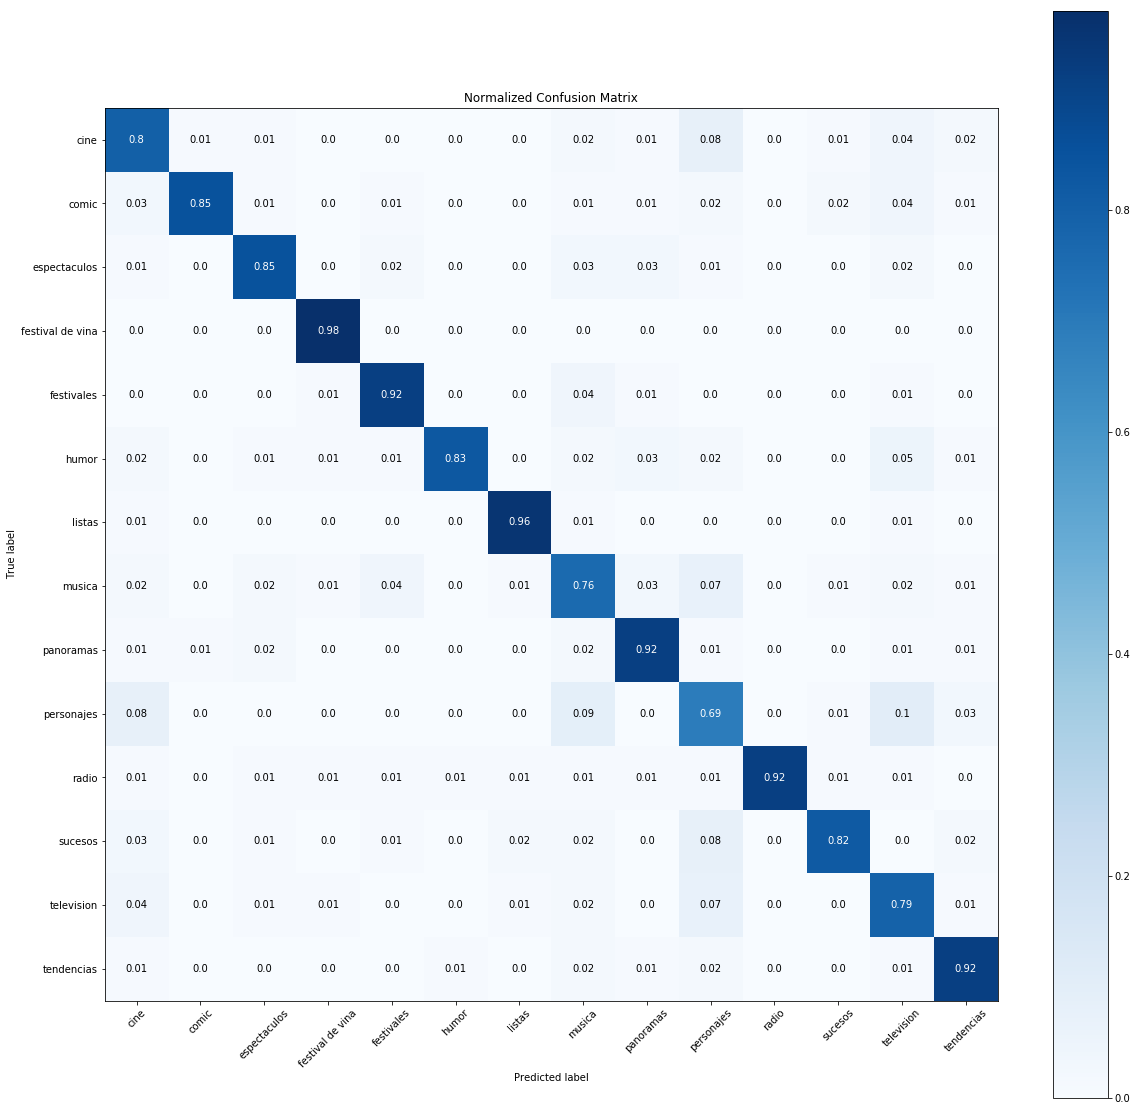

## sociedad

## Accuracy in test: 87.57954277633749 

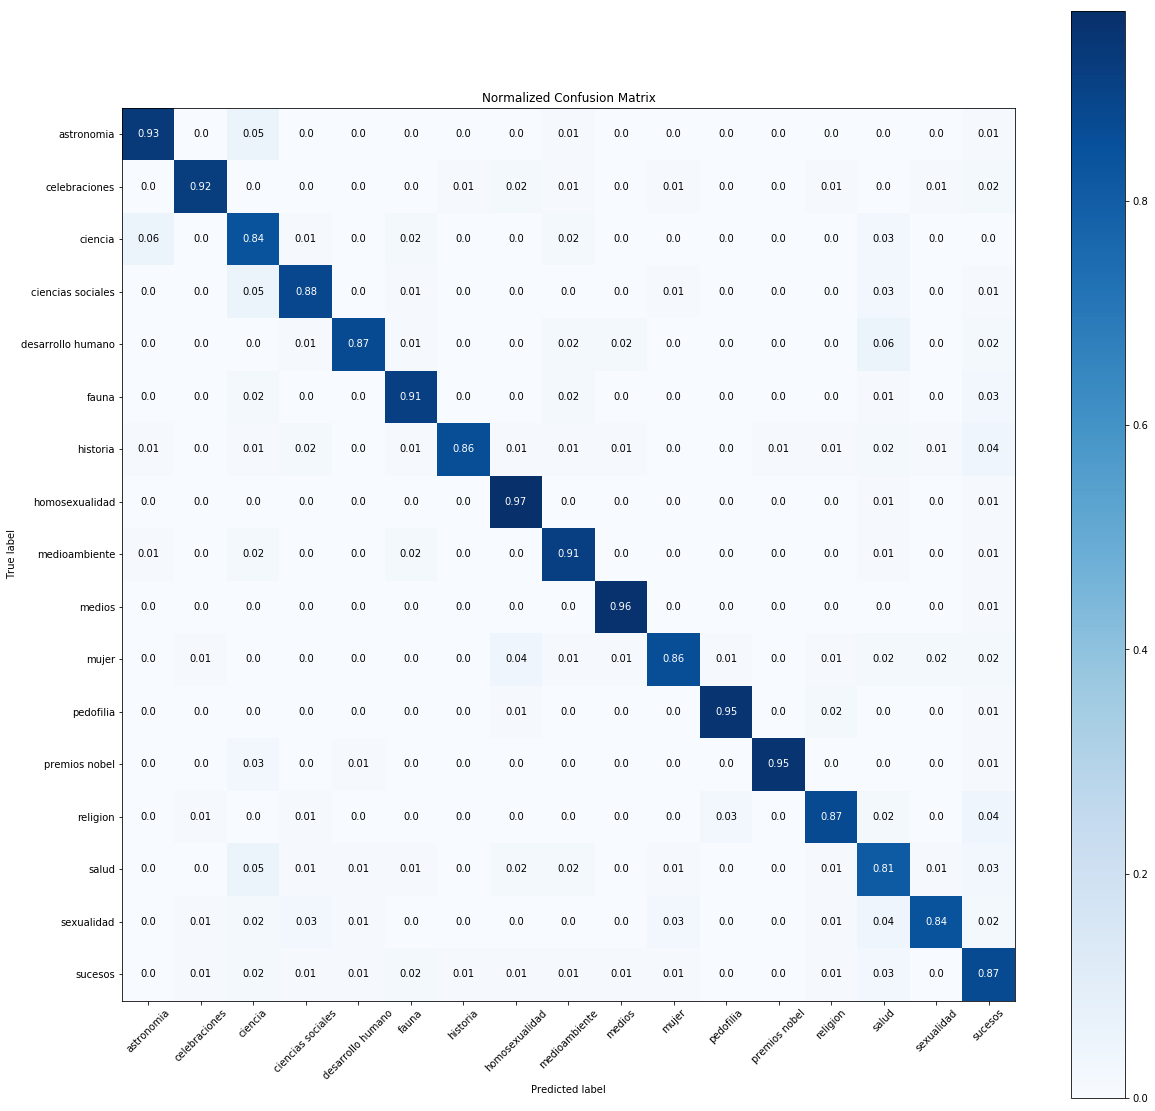

## pais

## Accuracy in test: 62.99166958725366 

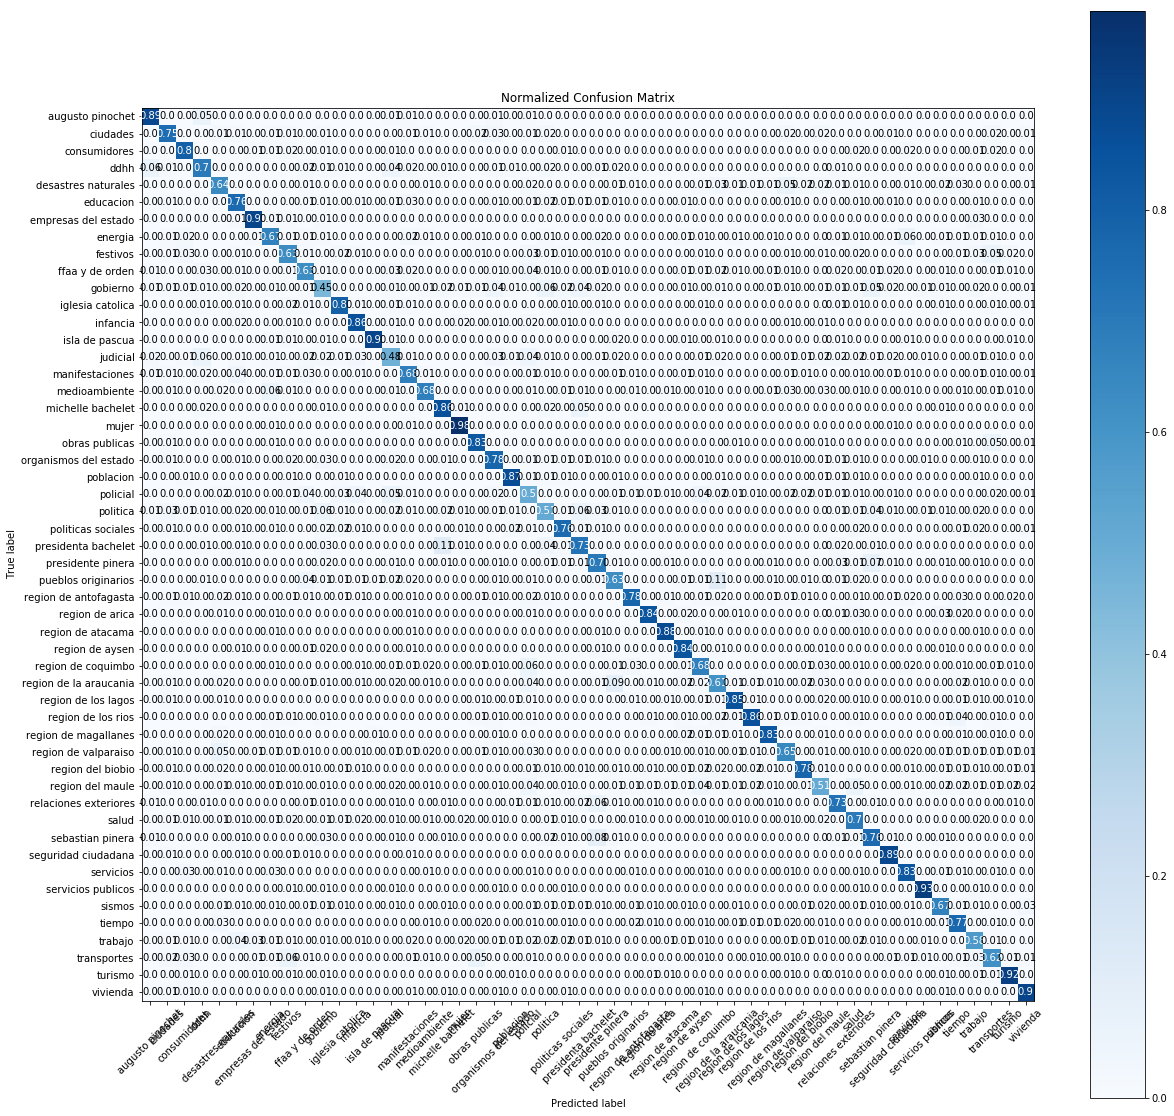

## economia

## Accuracy in test: 93.78396739130434 

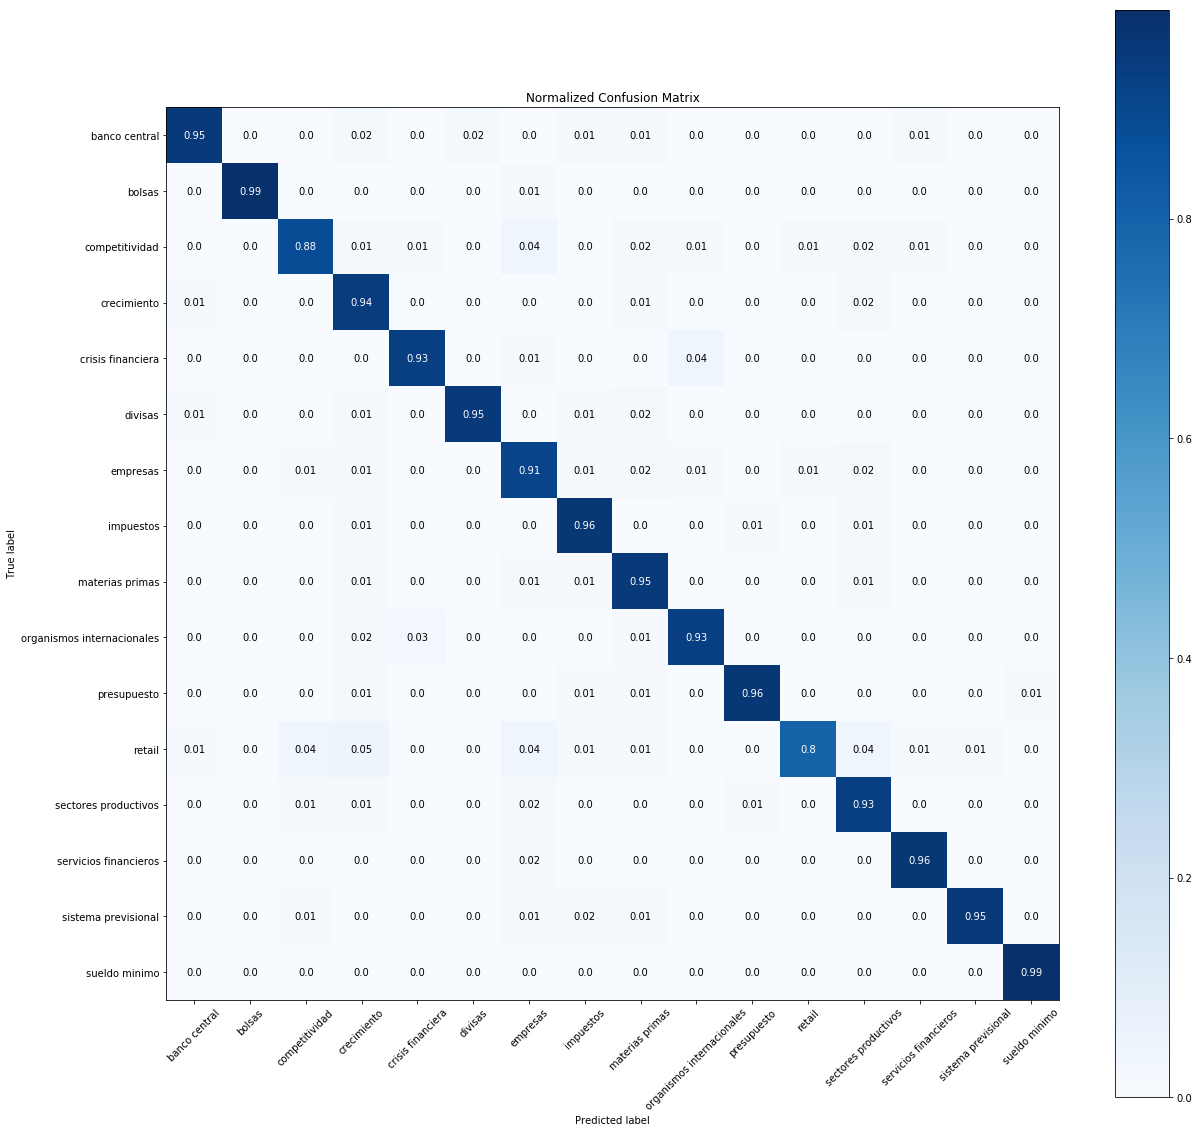

## tecnologia

## Accuracy in test: 94.00172612197929 

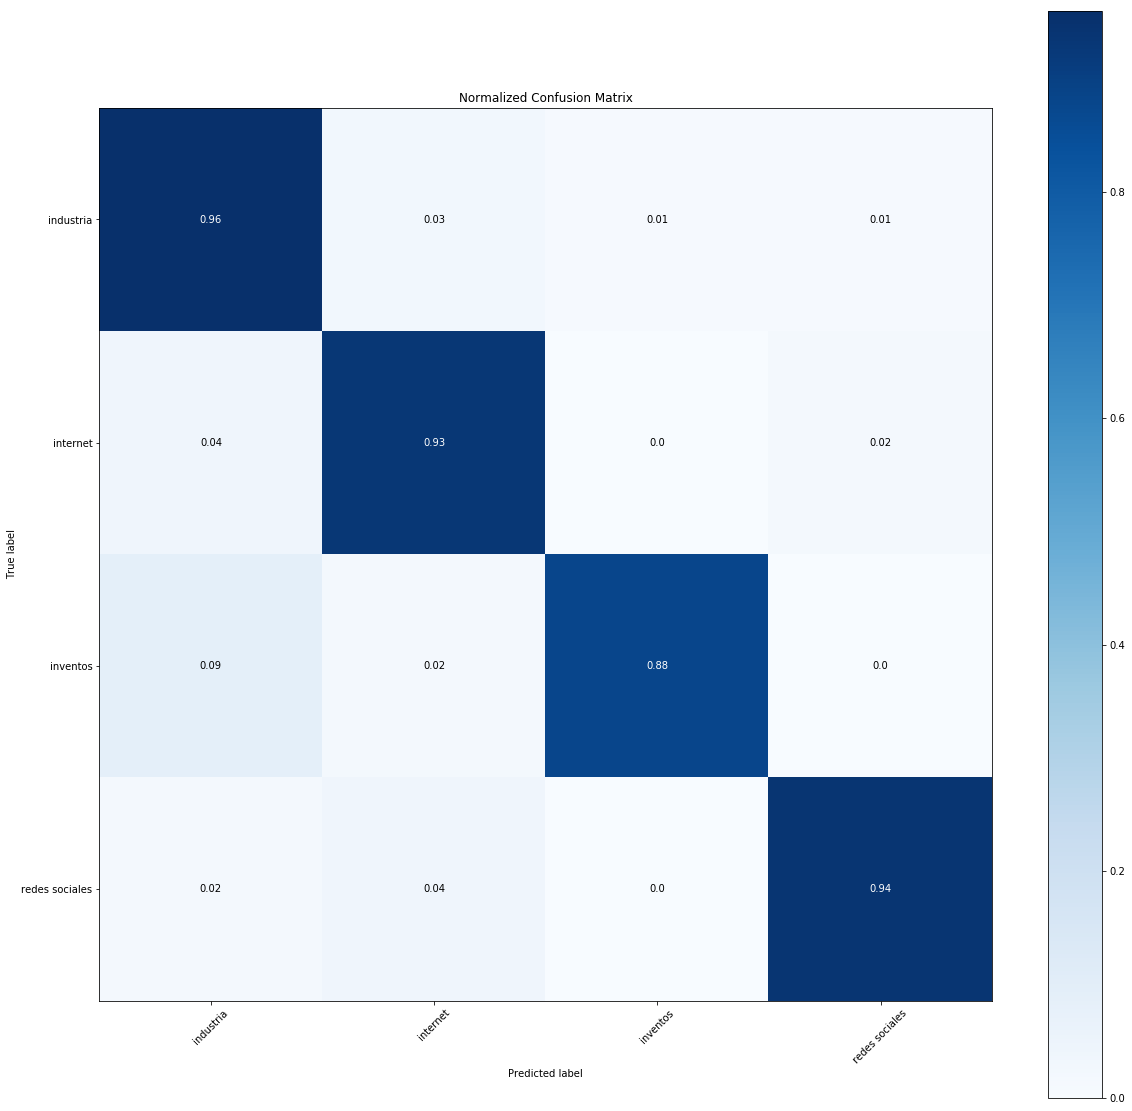

## deportes

## Accuracy in test: 74.06968787830938 

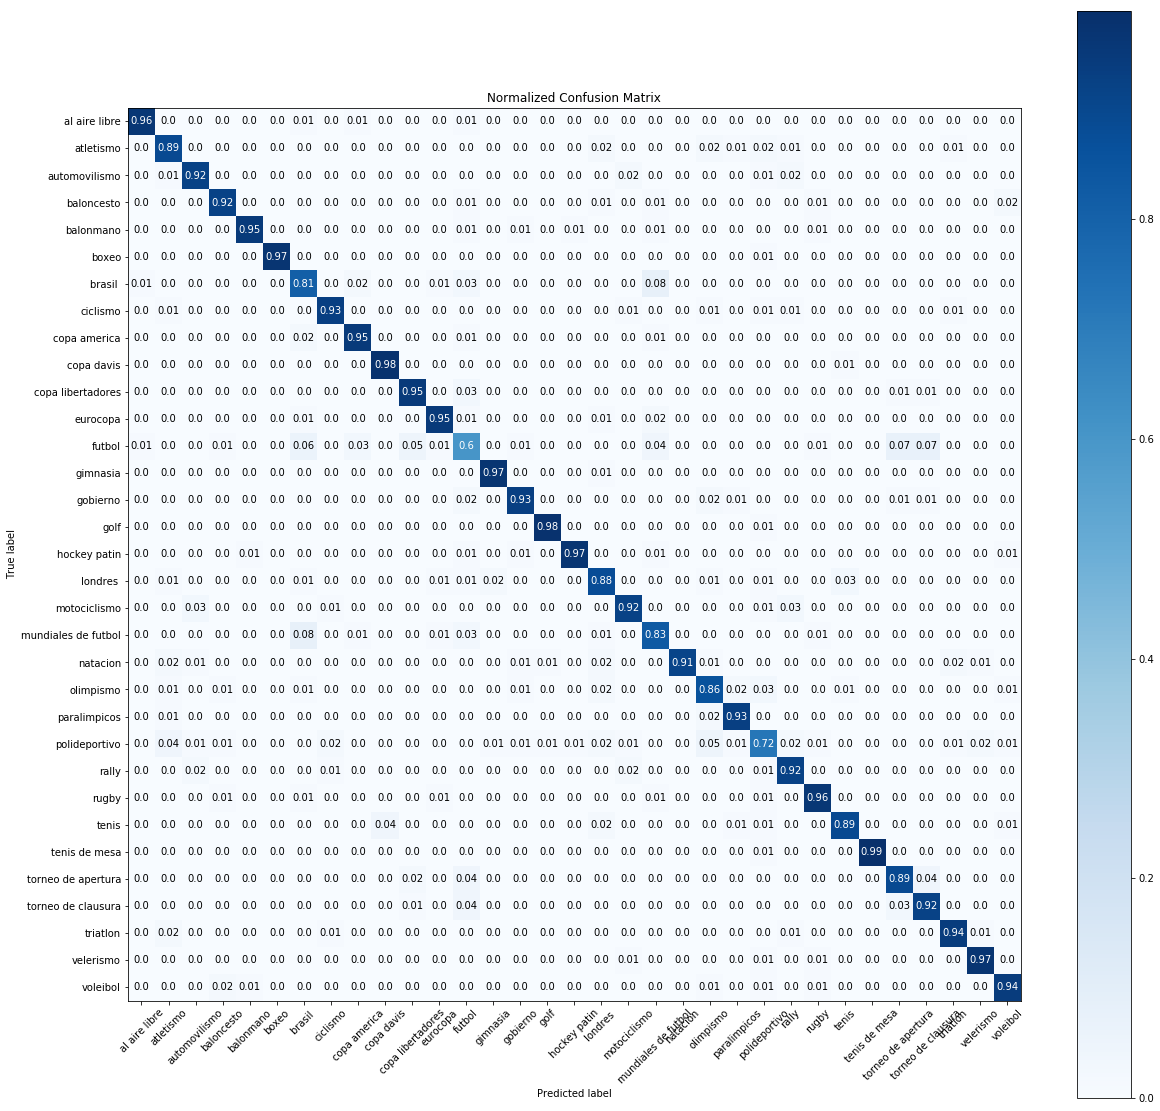

## cultura

## Accuracy in test: 97.4368639276291 

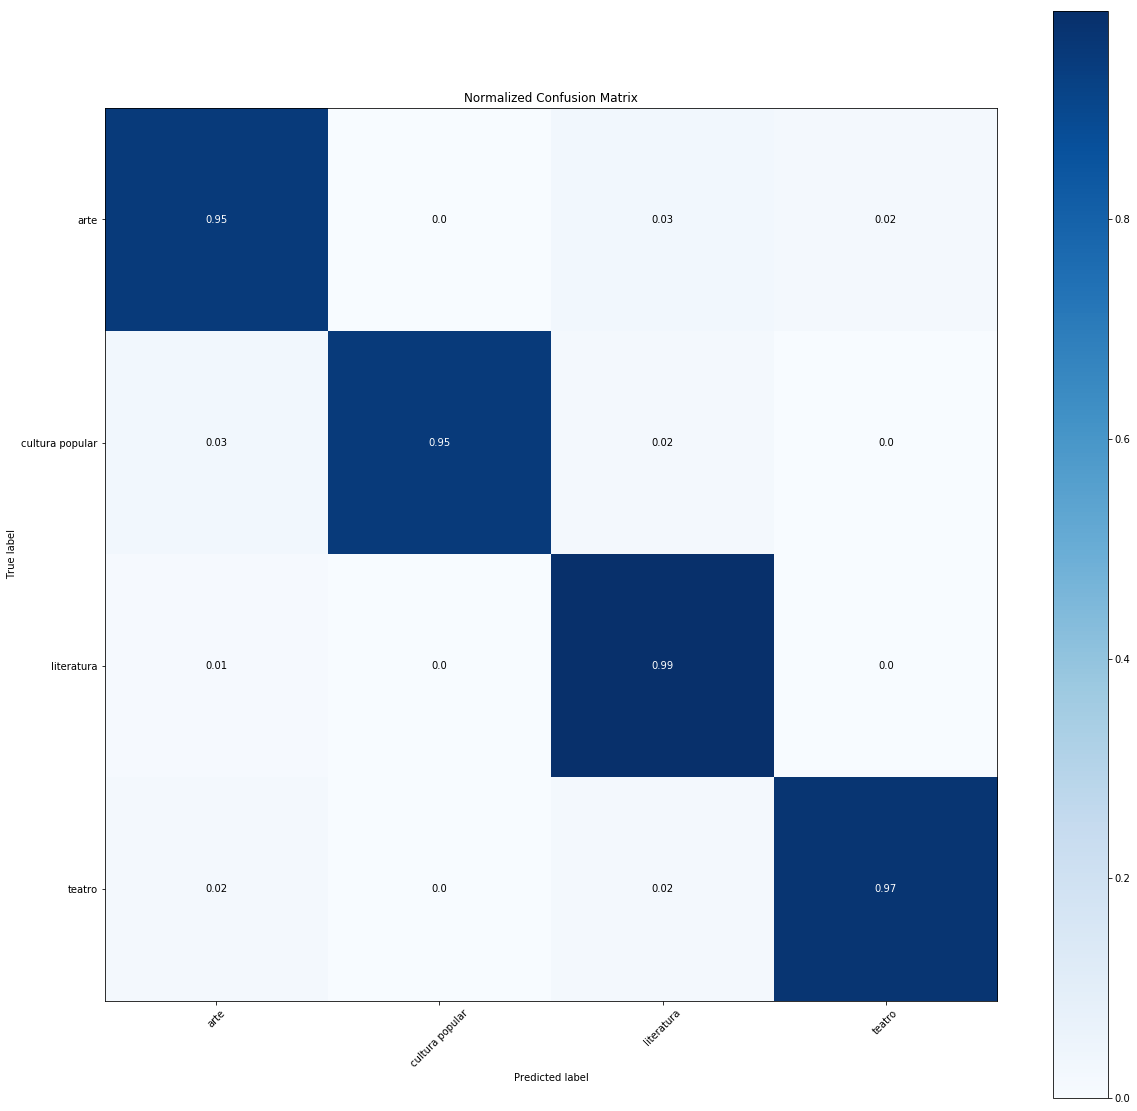

## mundo

## Accuracy in test: 77.6117496807152 

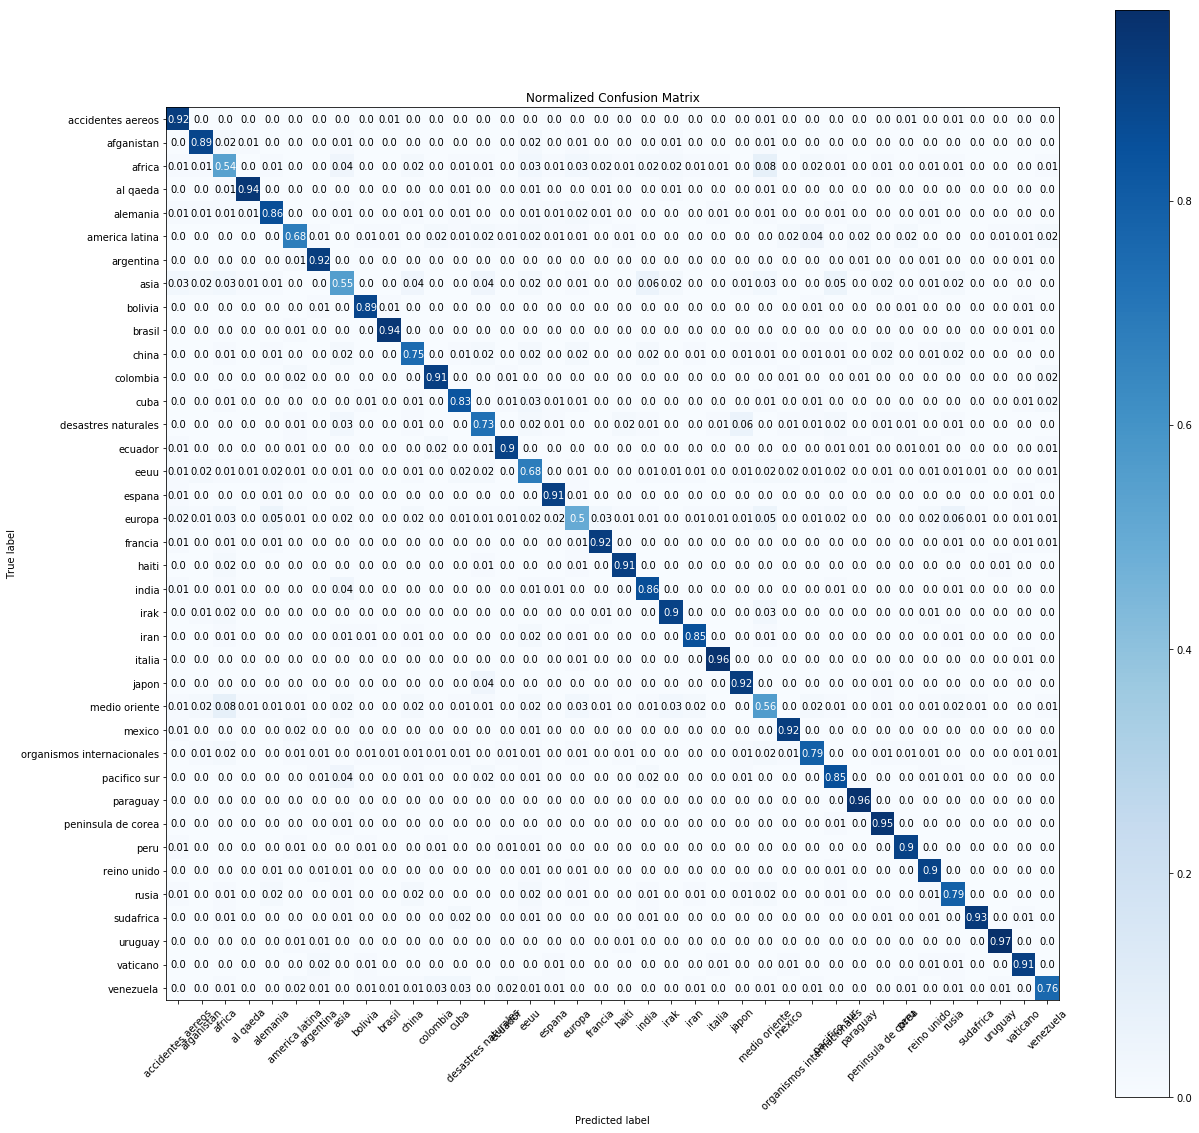

In [24]:
for key in labels:
    display(Markdown('## ' + key))
    display(Markdown('## Accuracy in test: {} '.format(acc[key]*100)))    
    skplt.metrics.plot_confusion_matrix(y_test[key], y_test_hat[key],normalize=True,figsize=(20,20))
    plt.xticks(rotation=45)
    plt.show()

    #print('Accuracy in test: {}'.format(acc))
